# Loading Data

In [4]:
import os
import tarfile
import urllib

In [31]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join("dataset", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [35]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [36]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [37]:
fetch_housing_data()

In [38]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [39]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [41]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [40]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


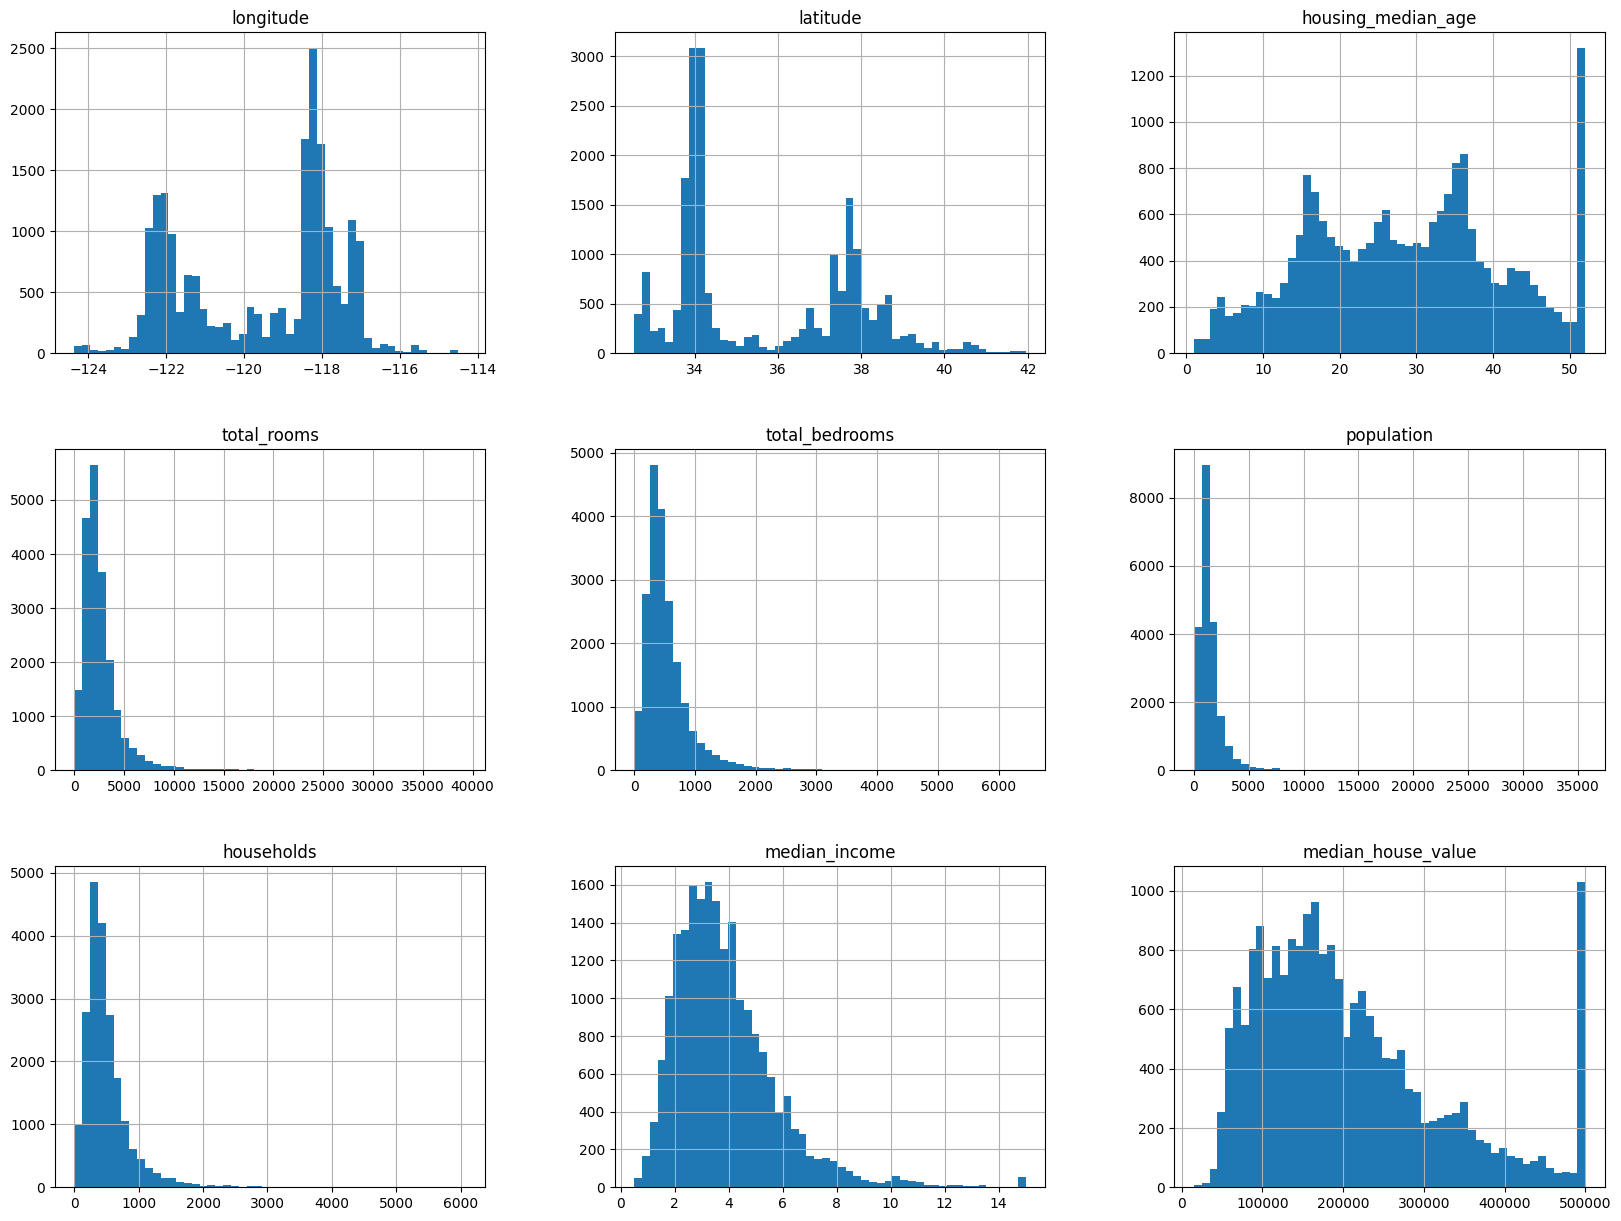

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

# Splitting Data into Sets

In [49]:
# non-reproducible splitting
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [50]:
train_set, test_set = split_train_test(data=housing, test_ratio=0.25)
print(len(train_set))
print(len(test_set))

15480
5160


In [51]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(identifier=id_, test_ratio=test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [52]:
# hash by index
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(data=housing_with_id, test_ratio=0.25, id_column='index')
print(len(train_set))
print(len(test_set))

15480
5160


In [53]:
# hash my coordinates
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(data=housing_with_id, test_ratio=0.25, id_column='id')
print(len(train_set))
print(len(test_set))

15396
5244


In [54]:
# splitting with scikit_learn
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.25, random_state=42)
print(len(train_set))
print(len(test_set))

15480
5160


<AxesSubplot: >

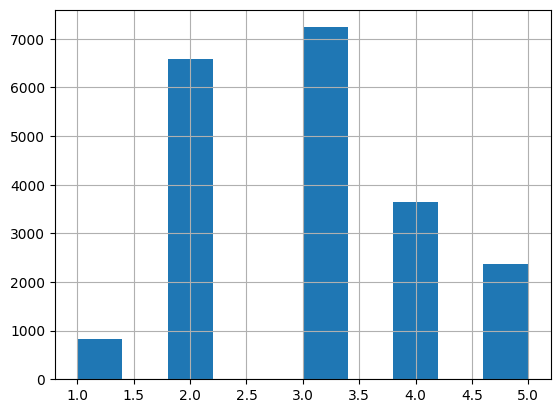

In [55]:
# stratify (i.e. categorize) a continuous variable
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0, 1.5, 3.0, 4.5, 6.0, np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].hist()

In [72]:
# stratified splitting
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=42)
for train_index, test_index in split.split(X=housing, y=housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    print(len(strat_train_set), len(strat_test_set))

15480 5160
15480 5160


In [73]:
# fraction of ocurrences per class
for set_ in (strat_train_set, strat_test_set):
    print(set_["income_cat"].value_counts() / len(set_))
print(housing["income_cat"].value_counts() / len(housing))

3    0.350581
2    0.318863
4    0.176292
5    0.114406
1    0.039858
Name: income_cat, dtype: float64
3    0.350581
2    0.318798
4    0.176357
5    0.114535
1    0.039729
Name: income_cat, dtype: float64
3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64


In [74]:
# remove the income_cat field from the resulting sets
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# Exploring Data

In [76]:
# we override "housing" to manipulate the training data without modifying the dataframe
housing = strat_train_set.copy()

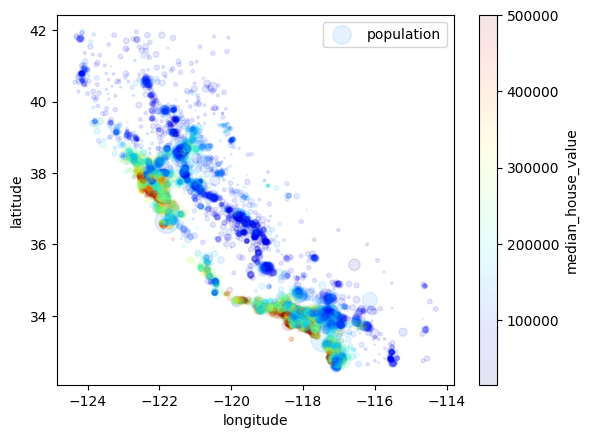

In [83]:
housing.plot(kind='scatter',
             x="longitude",
             y="latitude", 
             alpha=0.1, 
             s=housing['population']/100, 
             label='population',
             c='median_house_value',
             cmap=plt.get_cmap('jet'), 
             colorbar=True)
plt.legend()
plt.show()

In [80]:
# compute correlation matrix and show those for median_house_value
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

/var/folders/rx/y661s_v17xsf84wp1l5rc16h0000gn/T/ipykernel_4872/838077240.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value    1.000000
median_income         0.686875
total_rooms           0.135363
housing_median_age    0.101887
households            0.065527
total_bedrooms        0.049516
population           -0.026094
longitude            -0.047658
latitude             -0.142557
Name: median_house_value, dtype: float64

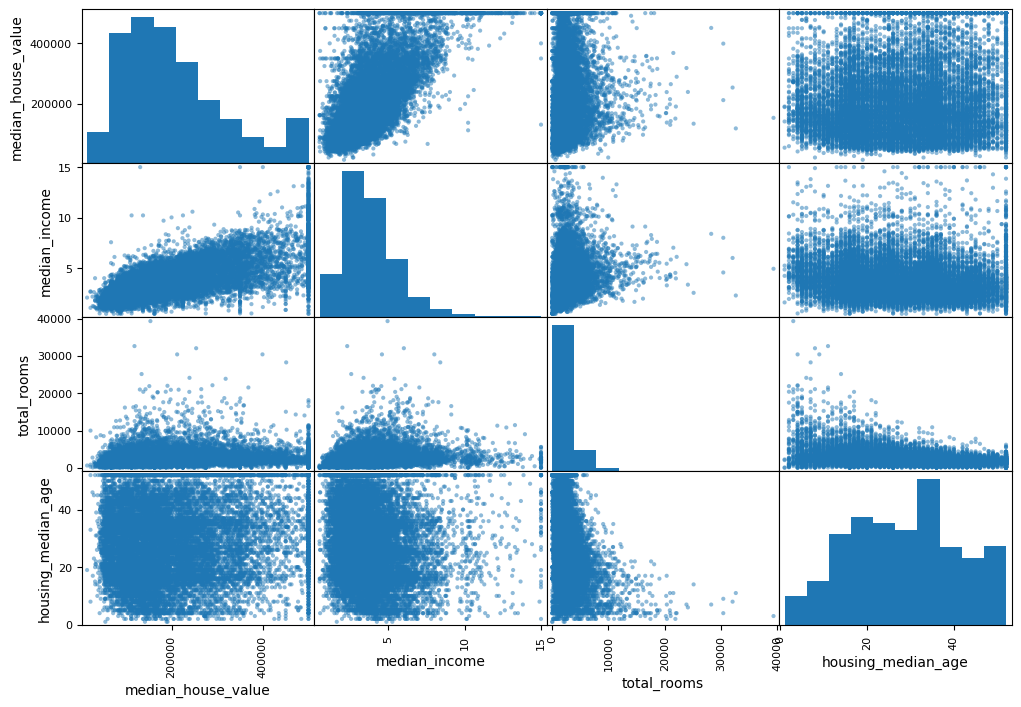

In [82]:
# scatter matrix
from pandas.plotting import scatter_matrix
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

# Feature Engineering

In [84]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [85]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

/var/folders/rx/y661s_v17xsf84wp1l5rc16h0000gn/T/ipykernel_4872/2905470689.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.686875
rooms_per_household         0.164375
total_rooms                 0.135363
housing_median_age          0.101887
households                  0.065527
total_bedrooms              0.049516
population_per_household   -0.022318
population                 -0.026094
longitude                  -0.047658
latitude                   -0.142557
bedrooms_per_room          -0.256697
Name: median_house_value, dtype: float64

# Data Cleaning

In [86]:
# copy again the train set in the more convenient variable "housing" and separate features from targets
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [87]:
# options to deal with nan values in "total_bedrooms"

# housing.dropna(subset=['total_bedrooms'])  # removes samples with nan total_bedrooms

# housing.drop('total_bedrooms', axis=1)  # removes the whole attribute total_bedrooms

# median = housiung['total_bedrooms'].median()  # imputes nan values with the median
# housing['total_bedrooms'].fillna(median, inplace=True)

### Imputation with Sklearn

In [90]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)  # make dataframe with only numerical columns (only numerical columns have a median)
imputer.fit(housing_num)  # computes median

SimpleImputer(strategy='median')

In [92]:
print(imputer.statistics_)  # medians
print(housing_num.median().values)  # also medians

[-118.5      34.26     29.     2125.      434.     1167.      409.
    3.5331]
[-118.5      34.26     29.     2125.      434.     1167.      409.
    3.5331]


In [96]:
X = imputer.transform(housing_num)  # imputes nan with medians. Returns an array
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15480 entries, 1049 to 12146
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15480 non-null  float64
 1   latitude            15480 non-null  float64
 2   housing_median_age  15480 non-null  float64
 3   total_rooms         15480 non-null  float64
 4   total_bedrooms      15480 non-null  float64
 5   population          15480 non-null  float64
 6   households          15480 non-null  float64
 7   median_income       15480 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


### Encoding Categorical Variables

In [97]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
1049,INLAND
15620,NEAR BAY
9929,NEAR BAY
12975,INLAND
17632,<1H OCEAN
20443,<1H OCEAN
18846,INLAND
12987,INLAND
20516,INLAND
18656,NEAR OCEAN


In [98]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [3.],
       [3.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [4.]])

In [101]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [102]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot  # sparse matrix, which is more efficient when there are many possible categories

<15480x5 sparse matrix of type '<class 'numpy.float64'>'
	with 15480 stored elements in Compressed Sparse Row format>

In [103]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [104]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custom Transformers

In [105]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):  # no *args or **kwargs because we inherit from BaseEstimator
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room is True:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Pipelines

In [106]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [109]:
 from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

# Training a Model

### Linear Regression

In [113]:
# Fit linear regressor
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [114]:
# run the whole pipeline on a subset
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions: ", lin_reg.predict(some_data_prepared))
print("Labels: ", list(some_labels))

Predictions:  [ 90240. 283904. 155136. 100352. 265856.]
Labels:  [134800.0, 500001.0, 177900.0, 125400.0, 253500.0]


In [115]:
# compute performance
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68798.79648617405

### Decision Tree Regressor

In [116]:
# fit a decision tree regressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [117]:
# compute performance
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_predictions, housing_labels)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


### Ensemble Learning - Random Forest Regressor

In [124]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [125]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_predictions, housing_labels)
forest_rmse = np.sqrt(forest_mse)
print(forest_rmse)

18635.164839763398


### K-fold Cross Validation

In [120]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

In [126]:
# do cross validation
from sklearn.model_selection import cross_val_score
# cross_val_score maximizes a utility function instead of minimizing a cost function
scores = cross_val_score(tree_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring='neg_mean_squared_error',
                         cv=10)
tree_rmse_scores = np.sqrt(-scores)

scores = cross_val_score(lin_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring='neg_mean_squared_error',
                         cv=10)
lin_rmse_scores = np.sqrt(-scores)

scores = cross_val_score(forest_reg, 
                         housing_prepared, 
                         housing_labels, 
                         scoring='neg_mean_squared_error',
                         cv=10)
forest_rmse_scores = np.sqrt(-scores)

In [127]:
display_scores(tree_rmse_scores)

Scores:  [71612.76508716 72724.60694885 70356.29815603 72775.82137669
 75177.48867022 70473.25139789 70806.15245968 73851.80349087
 69213.85088852 68853.33842817]
Mean:  71584.5376904079
Standard deviation:  1928.6918090357017


In [128]:
display_scores(lin_rmse_scores)

Scores:  [66454.5823061  69632.90092893 68668.77886074 71671.89589807
 72837.55210996 69666.58985797 70190.63846699 69564.24912621
 66254.11968552 67040.59789864]
Mean:  69198.1905139137
Standard deviation:  2049.924772390413


In [129]:
display_scores(forest_rmse_scores)

Scores:  [50353.96068374 49929.25438597 50562.30799335 51887.54156927
 49606.19414131 48730.99318101 51364.37396042 51930.74486393
 47106.60776623 49584.34189149]
Mean:  50105.63204367085
Standard deviation:  1407.0166648690547


# Saving a Model

In [130]:
import joblib
joblib.dump(lin_reg, "trained_models/lin_reg.pkl")
joblib.dump(tree_reg, "trained_models/tree_reg.pkl")
joblib.dump(forest_reg, "trained_models/forest_reg.pkl")

# my_model = joblib.load("trained_models/lin_reg.pkl")

['trained_models/forest_reg.pkl']

# Fine Tuning Parameters

In [132]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, 
                           param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [133]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [136]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

In [142]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.01543865e-02, 6.60124519e-02, 4.30973691e-02, 1.46535901e-02,
       1.41447227e-02, 1.48439083e-02, 1.35498042e-02, 3.67902077e-01,
       4.32226042e-02, 1.11471562e-01, 7.38416841e-02, 8.29067302e-03,
       1.52341889e-01, 2.66725606e-04, 2.32865350e-03, 3.87789932e-03])

In [137]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

64771.17791729046 {'max_features': 2, 'n_estimators': 3}
55164.92286406273 {'max_features': 2, 'n_estimators': 10}
53237.27576640071 {'max_features': 2, 'n_estimators': 30}
61275.49199861652 {'max_features': 4, 'n_estimators': 3}
52674.86560357464 {'max_features': 4, 'n_estimators': 10}
50715.110585026785 {'max_features': 4, 'n_estimators': 30}
58629.63238502298 {'max_features': 6, 'n_estimators': 3}
52398.89797098236 {'max_features': 6, 'n_estimators': 10}
50277.47619377031 {'max_features': 6, 'n_estimators': 30}
58913.272292512556 {'max_features': 8, 'n_estimators': 3}
51929.19035970963 {'max_features': 8, 'n_estimators': 10}
50090.64229456495 {'max_features': 8, 'n_estimators': 30}
63343.910612154665 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54339.89050773361 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59199.27232741566 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52381.511478524946 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [143]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36790207720742135, 'median_income'),
 (0.15234188858701134, 'INLAND'),
 (0.11147156156471258, 'pop_per_hhold'),
 (0.07384168412848317, 'bedrooms_per_room'),
 (0.07015438652408613, 'longitude'),
 (0.06601245186876861, 'latitude'),
 (0.04322260424155404, 'rooms_per_hhold'),
 (0.04309736909391065, 'housing_median_age'),
 (0.014843908317854407, 'population'),
 (0.014653590144170673, 'total_rooms'),
 (0.014144722656300984, 'total_bedrooms'),
 (0.013549804221253521, 'households'),
 (0.00829067302094162, '<1H OCEAN'),
 (0.0038778993176026436, 'NEAR OCEAN'),
 (0.002328653500003367, 'NEAR BAY'),
 (0.0002667256059248809, 'ISLAND')]

# Generalized Error

In [147]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
print(final_rmse)

48606.960226311916


In [148]:
# compute the 95% confidence interval of the generalized error
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence,
                         len(squared_errors) - 1, 
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([46705.7034036 , 50436.59816502])